## Coordinate-wise optimization

### Package

In [1]:
import scipy.optimize as opt
import numpy as np
from math import *
import matplotlib.pyplot as plt
from DataSet import generateDataSet
from igraph import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from igraph import *
from DataSet import generateDataSet

In [2]:
## Compute the lambdas
def strength(i,j,p,vec):
    summ = 0
    for l in range(p):
        summ += vec[i,l]*vec[j,l]
    return summ

# n : Population / p : Number of communities / k : Number of ranks / a,b : Gamma parameters / w = Community parameter
#/ rho : Data rho[i,j] jth selection of the ith person
def posterior(n,p,k,a,b,w,rho):
    vec = w.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            if vec[i,u] == 0:
                summa += (a-1)*log(0.0000000001) - b*vec[i,u]
            else:
                summa += (a-1)*log(abs(vec[i,u])) - b*vec[i,u]
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

In [3]:
# n : Population / p : Number of communities / k : Number of ranks / a,b : Gamma parameters / w = Community parameter
#/ rho : Data rho[i,j] jth selection of the ith person
def posteriorCorrection(n,p,k,w,rho):
    wPrior = w[:(p+2)]
    wLH = w[(p+2):]
    vec = wLH.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            if vec[i,u] == 0:
                summa += (wPrior[0]-1)*log(0.0000000001) - wPrior[1 + u]*vec[i,u]
            else:
                summa += (wPrior[0]-1)*log(abs(vec[i,u])) - wPrior[1 + u]*vec[i,u]
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

### Test Optimization

In [4]:
n = 40
p = 3
k = 4
a = 2
b = 1
def generateRank(n,k):
    sol = [np.random.choice([j for j in range(i)] + [j for j in range(i + 1,n)], k, replace = False) for i in range(n)]
    return np.array(sol)
rho = generateRank(n,k)
w = 10*np.random.rand(n*p - 1)
print(w)

[3.76117061 2.585256   3.0820865  2.89744263 6.40634146 8.30572268
 3.26549168 1.97409035 5.06494525 8.74595801 2.81370033 8.88955102
 1.65865919 7.64828598 3.13884956 2.60357714 2.70035689 2.17775376
 3.20481688 0.29261686 5.33724564 9.02675799 1.10781376 5.80230625
 1.50600717 3.32285936 1.85729698 3.05576643 4.62051928 9.10232229
 0.66884312 8.82856464 0.39528697 2.22030131 4.98409369 0.34425034
 3.723304   8.90219838 3.55965605 5.07011946 6.52767569 6.4555308
 4.58209849 5.84654505 5.85299622 5.8364581  0.67134497 8.94285229
 1.77375368 9.40035017 7.94530889 8.3134003  9.13504362 4.33568998
 0.80491033 6.78263388 5.75009036 9.95931848 3.27652544 9.03768234
 2.48530743 3.43983872 9.60952327 9.75664325 7.30364242 3.90204996
 4.12955946 3.91777821 2.17384188 4.18598053 5.81572725 0.27737982
 1.61985789 8.62567927 2.7775107  6.53917116 4.00664247 6.63776451
 7.91881054 1.49765243 5.33430035 4.2802871  2.7079458  1.73010668
 9.92364875 9.62114064 2.43890421 9.39984828 9.41019933 9.47131

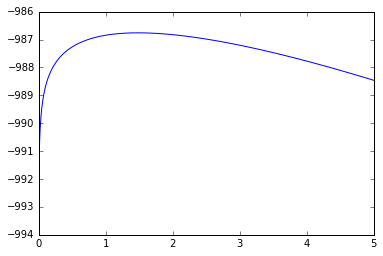

In [5]:
lin1 = np.linspace(0.001,5,750)
yVals = [posterior(n,p,k,a,b,np.insert(w,0,val),rho) for val in lin1]
plt.plot(lin1,yVals)
plt.savefig("CoordinateWiseFunction.png")

### Coordinate Wise Optimization

In [6]:
def optimizeCoor(n,p,k,a,b,rho,eps):
    w = 10*np.random.rand(n*p)
    val = posterior(n,p,k,a,b,w,rho)
    flag = True
    while flag:
        for i in range(n*p):
            w1 = np.delete(w,i)
            funcToOpt = lambda x : (-1)*posterior(n,p,k,a,b,np.insert(w1,i,x),rho)
            res, val1, msg = opt.fmin_l_bfgs_b(funcToOpt, np.array([w[i]]),approx_grad=True, bounds = [(0,+inf)])
            w = np.insert(w1,i,res)
        if abs(val1-val) < eps:
            return w, val1
        else:
            val = val1
        print(val)

### Global Optimization

In [7]:
def globalOpt(n,p,k,a,b,rho):
    w0 = 10*np.random.rand(n*p)
    functionToOpt = lambda w : (-1)*posterior(n,p,k,a,b,w,rho)
    result = opt.fmin_l_bfgs_b(functionToOpt, w0,approx_grad=True, bounds = [(0.000000001, +inf) for i in range(n*p)])
    return result

In [8]:
def globalOptCorrection(n,p,k,rho):
    w0 = 10*np.random.rand((n+1)*p + 1)
    functionToOpt = lambda w : (-1)*posterior(n,p,k,w,rho)
    result = opt.fmin_l_bfgs_b(functionToOpt, w0,approx_grad=True, bounds = [(0.000000001, +inf) for i in range((n+1)*p + 1)])
    return result

### Test on simulated Data

#### Data Generation

In [33]:
def drawGamma(a,b,n):
    return np.random.gamma(a,b,n)

def drawGammaCorr(a,listB, n):
    p = listB.shape[0]
    cur = np.random.gamma(a,listB[0],n)
    for i in range(p-1):
        np.concatenate((cur, np.random.gamma(a,listB[i+1],n).T))
    return cur
    
    
    
    
def computeStrength(n,p,w):
    w1 = w.reshape((n,p))
    return (np.array([strength(i,j,p,w1) if i != j else 0 for i in range(n) for j in range(n)])).reshape((n,n))
def computeRho(strengths,n,K):
    rho = np.zeros((n,K), dtype = int)
    for i in range(n):
        strength_i = strengths[i]
        strength_i_normalized = (1/(sum(strength_i)))*strength_i
        strength_i_cumulated = [(sum(strength_i_normalized[:(j+1)])) for j in range(n)]
        for j in range(K):
            r = np.random.rand()
            k = 0
            val = strength_i_cumulated[0]
            while r > val:
                k += 1
                val = strength_i_cumulated[k]
            rho[i,j] = k
            strengths[i,k] = 0
            strength_i = strengths[i]
            strengh_i_nomalized = (1/(sum(strength_i)))*strength_i
            strength_i_cumulated = [(sum(strength_i_normalized[:(l+1)])) for l in range(n)]
    return rho
def normalizeStrength(n,strengths):
    for i in range(n):
        strengths[i] = (1/sum(strengths[i]))*strengths[i]
    return strengths

In [38]:
L = [1,2,3,4]
L.T

AttributeError: 'list' object has no attribute 'T'

In [34]:
n = 15
p = 3
k = 3
a = 2
b = 1
w = drawGammaCorr(a,np.array([1,10,100]),n)
print(w)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
n = 15
p = 3
k = 3
a = 2
b = 1
w = drawGamma(a,b,n*p)
strengths = computeStrength(n,p,w)
rho = computeRho(strengths,n,k)

### Optimization Simulated Data

In [ ]:
def AE(w1,w2,n):
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip(w1,w2))))/n

def rankingGap(w1,w2,n):
    rk1 = [i for i in range(n)]
    rk2 = [i for i in range(n)]
    rk1 = sorted(rk1, key=lambda i: w1[i])
    rk2 = sorted(rk2, key=lambda i: w2[i])
    print(rk1)
    print(rk2)
    rk2 = [rk2.index(i) for i in rk1]
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip([i for i in range(n)],rk2))))/n

#### Test Coordinate Optimization

In [ ]:
eps = 0.000001
result = optimizeCoor(n,p,k,a,b,rho,eps)

#### Test Global Opti

In [ ]:
resultGlobal = globalOpt(n,p,k,a,b,rho)
print(resultGlobal)

### Result Obtained

#### Plot generated

In [ ]:
numInd = 0
strengthEstimated = normalizeStrength(n,computeStrength(n,p,result[0]))
strengths = normalizeStrength(n,computeStrength(n,p,w))
strengthEstimated = strengthEstimated.reshape((n*n,))
strengths = strengths.reshape((n*n,))
strengthGlb = normalizeStrength(n,computeStrength(n,p,resultGlobal[0]))
strengthGlb = strengthGlb.reshape((n*n,))
plt.plot([i for i in range(n)], strengths[numInd*n:(numInd+1)*n], '-b' ,label = 'Data initially sampled')
plt.plot([i for i in range(n)], strengthEstimated[numInd*n:(numInd+1)*n], '-r' , label = 'Coordinate Estimation')
plt.plot([i for i in range(n)], strengthGlb[numInd*n:(numInd+1)*n], '-g' ,label = 'Global optimization Estimation')
plt.legend()
#plt.title("Estimation of the link between the first individual with the others")
plt.savefig("LambdaEstimation")
plt.show()
print("Ranking Gap Coordinate", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("Ranking Gap Global", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

print("AE Coordinate", AE(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("AE Global", AE(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

#### Graph Comparison

In [ ]:
g = Graph(directed=True)
g.add_vertices(n)
comm = w.reshape((n,p))
for i in range(n):
    listToSort = [i for i in range(n)]
    listStrengthOrigin_i = strengths[i*n : (i+1)*n]
    listSorted = sorted(listToSort, key=lambda x: listStrengthOrigin_i[x])
    listSorted.reverse()
    print(listSorted)
    for j in range(k):
        g.add_edge(i,listSorted[j], width=j+1)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax(comm[i])] for i in range(n)]
out = plot(g)
out.save("OriginalPlot.png")
out

In [ ]:
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(k):
        g.add_edge(i,rho[i,j], width=j+1)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax((resultGlobal[0].reshape((n,p)))[i])] for i in range(n)]
out = plot(g)
out.save("OptimizationPlot.png")
out

## Test on Sampson's Monks dataset

#### Import Data

In [ ]:
(listData,listLabel) = generateDataSet()
arr1 = listData[0]
arr2 = listData[1]
arr3 = listData[2]
(n,p) = arr1.shape
print(arr1)
print(arr2)
print(arr3)

In [ ]:
finalArray = np.zeros((n,p))
for i in range(n):
    for j in range(p):
        if arr1[i][j] != 0 or arr2[i][j] != 0 or arr3[i][j] != 0:
            finalArray[i][j] = 1
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(p):
        if finalArray[i][j] == 1:
            g.add_edge(i,j, width= 2)
g.vs["label"] = listLabel
colors = ["red", "green", "blue"]
g.vs["color"] = ["Grey"]
plot(g)

In [ ]:
n = 18
k = 3
a = 2
b = 1
p = 3
rho = np.zeros((n,3), dtype = int)
for i in range(n):
    for j in range(k):
        rho[i][j] = (arr3[i].tolist()).index(j+1)
print(rho)

In [ ]:
resultGlobalSam = globalOpt(n,p,k,a,b,rho)
print(resultGlobalSam)

In [ ]:
eps = 0.000001
result = optimizeCoor(n,p,k,a,b,rho,eps)

In [ ]:
print(result)

In [ ]:
numInd = 0
strengthEstimated = normalizeStrength(n,computeStrength(n,p,result[0]))
strengthEstimated = strengthEstimated.reshape((n*n,))
strengthGlb = normalizeStrength(n,computeStrength(n,p,resultGlobalSam[0]))
strengthGlb = strengthGlb.reshape((n*n,))
plt.plot([i for i in range(n)], strengthEstimated[numInd*n:(numInd+1)*n], '-r' , label = 'Coordinate Estimation')
plt.plot([i for i in range(n)], strengthGlb[numInd*n:(numInd+1)*n], '-g' ,label = 'Global optimization Estimation')
plt.legend()
#plt.title("Estimation of the link between the first individual with the others")
#plt.savefig("LambdaEstimation")
#plt.show()
print("Ranking Gap Coordinate", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("Ranking Gap Global", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

print("AE Coordinate", AE(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("AE Global", AE(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

In [ ]:
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(k):
        g.add_edge(i,rho[i,j], width=j+1)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax((resultGlobalSam[0].reshape((n,p)))[i])] for i in range(n)]
out = plot(g)
out.save("OptimizationPlotSam.png")
out